# Global Peatland Assessment

**Objectives**
1. Estimate Peat area 
2. Estimate Degradation Peat based on Hansen Forest and Humid Tropical Forest. <br>
*Note: Degraded peat is assumed as non-forested peat in 2000 and 2022*

**Data Source**
1. PEATMAP
Xu, Jiren and Morris, Paul J. and Liu, Junguo and Holden, Joseph (2017) PEATMAP: Refining estimates of global peatland distribution based on a meta-analysis. University of Leeds. [Dataset] https://doi.org/10.5518/252
2. Hansen Tree Cover and Forest Loss
Hansen, M. C., P. V. Potapov, R. Moore, M. Hancher, S. A. Turubanova, A. Tyukavina, D. Thau, S. V. Stehman, S. J. Goetz, T. R. Loveland, A. Kommareddy, A. Egorov, L. Chini, C. O. Justice, and J. R. G. Townshend. 2013. "High-Resolution Global Maps of 21st-Century Forest Cover Change." Science 342 (15 November): 850-53. 10.1126/science.1244693 Data available on-line at: https://glad.earthengine.app/view/global-forest-change.
3. Primary Humid Tropical Forest
Turubanova S., Potapov P., Tyukavina, A., and Hansen M. (2018) Ongoing primary forest loss in Brazil, Democratic Republic of the Congo, and Indonesia. Environmental Research Letters. https://doi.org/10.1088/1748-9326/aacd1c

## Data Preparation

### Import modules and Relevant Datasets

In [1]:
%matplotlib inline
import os
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from geemap import cartoee
import geoplot.crs as gcrs
import mapclassify as mc
import cartopy.io.img_tiles as cimgt

In [2]:
import ee
import geemap
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
peat_directory = filedialog.askopenfile(title = "Open Peatland Shapefile")
# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [4]:
# output directory
out_dir = os.path.expanduser(output_directory+'/geemap_degradedPeat_Hansen')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Specify Input Data

In [6]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Jambi
All data will be reprojected to  EPSG:32748  canopy cover
Column name is  PROVINSI


In [7]:
### specify for Hansen

#Specify forest_threshold
forest_threshold = simpledialog.askinteger("Input", "Specify forest threshold value to define forest",parent=root , 
                                           minvalue =0, maxvalue = 100)

if forest_threshold is not None:
    print("Forest is defined as area with >= ", forest_threshold, ' canopy cover')
else:
    print("Forest Threshold has not specified, Restart the code!")
    
# Specify minimum mapping unit - forest
min_forest_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                              parent=root , minvalue =0, maxvalue = 100)

if min_forest_map_area is not None:
    print("Minimum pixels size is ", min_forest_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

pixels = ee.Number(min_forest_map_area)
    
# Specify minimum mapping unit - forest loss
min_forestloss_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                                  parent=root , minvalue =0, maxvalue = 100)

if min_forestloss_map_area is not None:
    print("Minimum pixels size is ", min_forestloss_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

lossPixels = ee.Number(min_forestloss_map_area); 



Forest is defined as area with >=  30  canopy cover
Minimum pixels size is  6
Minimum pixels size is  6


In [8]:
# tile scale to avoid memory ran out issue
tileScale = 4

## Peat Area Estimation

In [9]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
peat = gpd.read_file(peat_directory.name)

# reproject to UTM
roi_proj  = roi.to_crs(crs = projection)
peat_proj = peat.to_crs(crs = projection)

In [10]:
# clip peatland by roi then union with roi to create peat and non-peat
# peat : 1
# non-peat: 2
peat_roi_proj = gpd.clip(peat_proj, roi_proj)
peat_roi_proj["Data"] = 1
peat_roi_proj["Data_cat"] = "Peat"
peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union", keep_geom_type=False)

In [ ]:
# incase topological error is encounterd in the union process

try:
    peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union", keep_geom_type=False)
except (TopologicalError, TopologyException):
    #skipping error here
    pass

In [11]:
# calculate peat and non-peat area
peat_nonpeat_roi_proj["Area_Ha"] = peat_nonpeat_roi_proj['geometry'].area/10000
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.fillna(2)
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.astype('int64')
peat_nonpeat_roi_proj.Data_cat = peat_nonpeat_roi_proj.Data_cat.fillna("Non-peat")

In [12]:
# create new ID
peat_nonpeat_roi_proj['new_id'] = np.arange(len(peat_nonpeat_roi_proj))

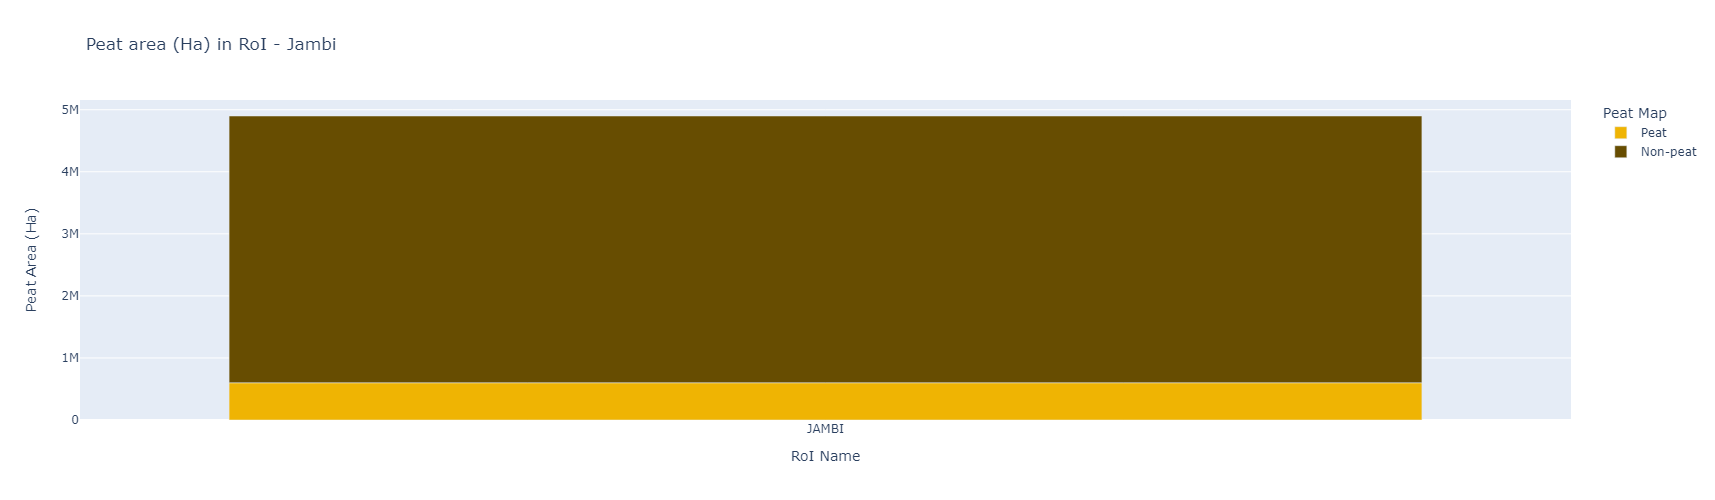

In [13]:
# Peat area in RoI
fig_peatarea = px.bar(peat_nonpeat_roi_proj, x = peat_nonpeat_roi_proj[roi_column_name],
                      y =peat_nonpeat_roi_proj.Area_Ha, color = 'Data_cat',
                      category_orders={"Peat Map": ["Peat", "Non-peat"]},
                      color_discrete_sequence = ['#efb403', '#674d01'],
                      width=1400, height=500, 
                      labels = {roi_column_name: "RoI Name","Area_Ha": "Peat Area (Ha)"},
                      title ="Peat area (Ha) in RoI - " + projectname)
fig_peatarea.update_layout(legend_title_text='Peat Map')

## Hansen Assessment on Peat

In [14]:
# Convert to ee.FeatureCollection for calculation process
peat_roi_proj_gee = geemap.geopandas_to_ee(peat_roi_proj, geodesic = False)
peat_nonpeat_roi_proj_gee = geemap.geopandas_to_ee(peat_nonpeat_roi_proj, geodesic=False)
roi_proj_gee = geemap.geopandas_to_ee(roi_proj, geodesic=False)

In [15]:
# Import Hansen image dataset
Hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
primaryForests = ee.ImageCollection("UMD/GLAD/PRIMARY_HUMID_TROPICAL_FORESTS/v1").mosaic().selfMask();

# Select bands
treeCover = Hansen.select(['treecover2000']);
lossImage = Hansen.select(['loss']);
gainImage = Hansen.select(['gain']);
lossImage_year = Hansen.select(['lossyear']);
landmask = Hansen.select(['datamask']);

In [16]:
# Reproject Image to UTM
treeCover_proj = treeCover.reproject(crs = projection, scale = 30)
lossImage_proj = lossImage.reproject(crs = projection, scale = 30)
lossImage_year_proj = lossImage_year.reproject(crs = projection, scale = 30)
landmask_proj = landmask.reproject(crs = projection, scale = 30)
primaryForests_proj = primaryForests.reproject(crs = projection, scale = 30)

In [17]:
# 1. Primary Forest 2001
primaryForestContArea = primaryForests_proj.connectedPixelCount();
# Apply the minimum area on primary forest
primaryForestMinArea = primaryForestContArea.gte(pixels).selfMask();

In [18]:
# 2 Forest Map in 2000 (Non-primary forest 2000)
# 2.1 Define forest area by >= canopy cover
forest_canopy = treeCover_proj.gte(forest_threshold);

# 2.2 Define non-primary forest from pirmary forest dataset
primaryForestUnmask = primaryForestMinArea.unmask();
primaryForestEq0 = primaryForestUnmask.select('Primary_HT_forests').eq(0);

# 2.3 Mask forest canopy cover threshold with nonprimary forest
forestCC = forest_canopy.updateMask(forest_canopy.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(primaryForestEq0);

# 2.4 Apply smoothing
forestContArea = forestCC.connectedPixelCount();
forestMinArea = forestContArea.gte(pixels).selfMask();

In [19]:
# 3 Accumulated Forest loss 2001-2021:

# 3.1 Accumulated Forest Loss in non-primary forest loss
# 3.1.1 Estimate forest loss in forest 2000 >= Canopy cover
maskerforestLoss = lossImage_year_proj.gte(1);
forestLoss = lossImage_proj .updateMask(forestCC.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerforestLoss);
## Create a contiguous area.
contLoss = forestLoss.connectedPixelCount();
minLoss = contLoss.gte(lossPixels).selfMask();

# 3.2 Accumulated Forest Loss 2002-2021 in Primary Forest
# 3.2.1 Estimate forest loss exclusively in primary forest
MaskedPrimaryLoss= lossImage_year_proj.gte(2); ##// loss between 2002-2021
primaryLoss = lossImage_year_proj.updateMask(MaskedPrimaryLoss).updateMask(primaryForestMinArea).updateMask(landmask_proj.eq(1))
# 3.2.2 primary loss filtered by min mapping area
contPrimaryLoss= primaryLoss.connectedPixelCount();
minPrimaryLoss = contPrimaryLoss.gte(lossPixels).selfMask();

In [20]:
# 4 Annual Forest Loss 2001-2021
# 4.1 Non-primary forest
AnnualTreeLoss = lossImage_year_proj.updateMask(forestMinArea.eq(1)).updateMask(landmask_proj.eq(1))
## Create a contiguous area.
contAnnualLoss = AnnualTreeLoss.connectedPixelCount();
minAnnualLoss = contAnnualLoss.gte(lossPixels).selfMask();
minAnnualloss_masked = lossImage_year_proj.updateMask(minAnnualLoss)

# 4.2 Primary Forest
annual_PrimaryLoss = lossImage_year_proj.updateMask(primaryForestMinArea.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(MaskedPrimaryLoss.eq(1))
##** var primaryForestLoss = primaryLoss.updateMask(primaryForestMinArea);
##** Create contiguous area within primary forest loss
contAnnualPrimaryLoss = annual_PrimaryLoss.connectedPixelCount();
minAnnualPrimaryLoss = contAnnualPrimaryLoss.gte(lossPixels).selfMask();
minAnnualPrimaryLoss_masked = annual_PrimaryLoss.updateMask(minAnnualPrimaryLoss)

In [21]:
# 5. Primary Forest 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
PrimaryMinLossUnmask = minPrimaryLoss.unmask();
PrimaryNotLoss = PrimaryMinLossUnmask.select('lossyear').eq(0);
PrimaryForestCover22 = primaryForestMinArea.updateMask(PrimaryNotLoss);

In [22]:
# 6 Forest Map in 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
minLossUnmask = minLoss.unmask();
notLoss = minLossUnmask.select('loss').eq(0);
primaryForestUnmask = primaryForestMinArea.unmask();
notprimaryForest = primaryForestUnmask.select('Primary_HT_forests').eq(0);
forestCover22 = forestMinArea .updateMask(notLoss).updateMask(notprimaryForest);

In [23]:
# clip raster by roi, buffer 3km, buffer 10km to avoid error
# 1. Forest 2000 and 2022
FNF_00_Final = forestMinArea.clip(roi_proj_gee)
FNF_22_Final = forestCover22.clip(roi_proj_gee)

# 2. Primary Forest 2000
PF_00_Final = primaryForestMinArea.clip(roi_proj_gee)
PF_22_Final = PrimaryForestCover22.clip(roi_proj_gee)

# 3. Annual Forest Loss 2001-2022
Annual_FL_01_21_Final = minAnnualloss_masked.clip(roi_proj_gee)

# 4. Annual Primary Forest Loss 2001-2022
Annual_PFL_01_21_Final = minAnnualPrimaryLoss_masked.clip(roi_proj_gee)

In [24]:
# Visualization Parameters
# Forest 2000- Green
vis_treecover = {'palette': ['000000', '00FF00'], 'max': 100};
# Accumulated Forest Loss 2001-2020
vis_loss = {'palette': ['FF0000']};
# Annual forest loss 2001-2020
vis_loss_year = {'palette': ['blue', 'red'], 'min':1, 'max': 21};
vis_prim_loss_year = {'palette': ['blue', 'yellow', 'red'], 'min':2, 'max': 21};
# Forest non forest map
vis_forestnonforest = {'palette': ['yellow','#008000'], 'min':0, 'max':1};

# roi polygon
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

In [51]:
Map = geemap.Map()
Map.centerObject(roi_proj_gee, 10)

# 1. RoI and buffer
Map.addLayer(peat_nonpeat_roi_proj_gee.style(**vis_roi), {}, "Region of Interest")
# 2 Forest in 2000
Map.addLayer(forestMinArea.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, "Forest/Non-forest 2000")
Map.addLayer(primaryForestMinArea.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Primary Forest 2001')
# 3 Forest Loss in 2001 -2021
Map.addLayer(minLoss.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Accumulated Forest Loss 2001-2021")
Map.addLayer(minPrimaryLoss.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Accumulated Forest Loss in Primary Forest 2001-2021")
Map.addLayer(minAnnualloss_masked.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Annual Forest Loss 2001-2021", False)
Map.addLayer(minAnnualPrimaryLoss_masked.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, 'Annual Primary Forest Loss 2001-2021', False)

# 4. Forest in 2022
#Map.addLayer(forestCover22.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Forest/Non-forest 2022',False)
#Map.addLayer(PrimaryForestCover22.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Primary Forest 2022',False)

# 5. global
#Map.addLayer(minAnnualloss_masked, vis_loss_year, "Global Annual Forest Loss 2001-2021", False)
#Map.addLayer(primaryForestMinArea, vis_forestnonforest, 'global primary forest 2001')
#Map.addLayer(minAnnualPrimaryLoss_masked, vis_loss_year, 'global annual primary forest loss 2001-2022')

Map

Map(center=[-1.698463590692844, 102.71996498503798], controls=(WidgetControl(options=['position', 'transparent…

In [25]:
# visualization parameters
roi_kwargs = {'linewidth': 0.5, 'edgecolor': 'white'}
peat_kwargs = {'linewidth' : 0.5, 'edgecolor': None, 'facecolor': '#efb403'}
colors_peat = ['#efb403', '#674d01']
colormap = LinearSegmentedColormap.from_list([1, 2],colors_peat)

In [26]:
peat_roi_proj_4326 = peat_roi_proj.to_crs(crs = 'EPSG:4326')
roi_proj_4326 = roi_proj.to_crs(crs = 'EPSG:4326')
peat_nonpeat_roi_proj_4326 = peat_nonpeat_roi_proj.to_crs(crs = 'EPSG:4326')
#scheme = mc.Quantiles(continental_usa_cities['POP_2010'], k=5)
scheme_pnp = mc.UserDefined(peat_nonpeat_roi_proj_4326['Data'], bins = [1, 2])

<Figure size 2160x2160 with 0 Axes>

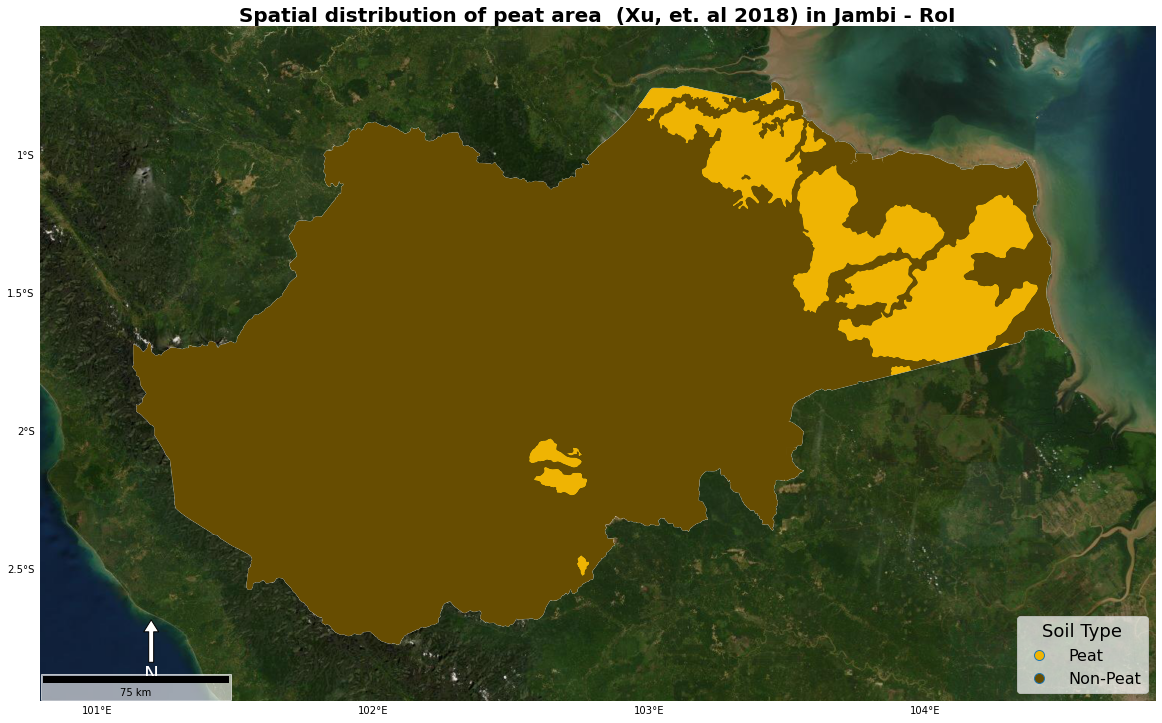

In [27]:
# Peat Map
fig_peat = plt.figure(figsize=(30,30), facecolor = 'white', frameon=True)
ax_peat = gplt.webmap(df=roi_proj_4326, projection=gcrs.WebMercator(),
                      provider=ctx.providers.Esri.WorldImagery, figsize=(20,20))
ax_peat = gplt.polyplot(roi_proj_4326, projection = gcrs.WebMercator(), **roi_kwargs, ax = ax_peat)

#ax_peat = gplt.polyplot(peat_roi_proj_4326, projection = gcrs.WebMercator(), **peat_kwargs, ax = ax_peat)
ax_peat = gplt.choropleth(peat_nonpeat_roi_proj_4326, hue='Data', projection=gcrs.WebMercator(),    
                          edgecolor = None, linewidth = 0.5, cmap=colormap,
                          legend=True, ax = ax_peat,
                          legend_kwargs={'frameon': True, 'framealpha' : 0.7, 'loc': 'lower right', 'fontsize' : 16, 'title':'Soil Type', 'title_fontsize' : 18},
                          legend_labels=['Peat', 'Non-Peat'],
                          scheme = scheme_pnp
)

x, y, arrow_length = 0.1, 0.12, 0.08
ax_peat.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='white', width=5, headwidth=15),
                 ha='center', va='center', fontsize=20,
                 xycoords=ax_peat.transAxes)


ax_peat.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_peat = ax_peat.gridlines(visible = None, draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax_peat.top_labels=False
ax_peat.right_labels = False
plt.title("Spatial distribution of peat area  (Xu, et. al 2018) in " +  projectname + " - RoI", va = 'center_baseline', fontsize=20, fontweight="bold")
#plt.title('Spatial distribution of peat area  (Xu, et. al 2018)',  fontsize=12, style='italic')
plt.savefig(os.path.join(out_dir, projectname + '_PeatDistribution_Map.png'), bbox_inches='tight', 
            facecolor=fig_peat.get_facecolor())

In [55]:
# 1. Forest Map 2000 - Peat and Non-peat RoI
geemap.ee_export_image_to_drive(
    FNF_00_Final,
    description = projectname + '_Forest_2000_roi',
    folder = projectname + '_Hansen_Assessment_PeatNonPeat',
    fileNamePrefix = projectname + '_Forest_2000_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 2. Forest Map 2022 - Peat and Non-peat RoI
geemap.ee_export_image_to_drive(
    FNF_22_Final,
    description = projectname + '_Forest_2022_roi',
    folder = projectname + '_Hansen_Assessment_PeatNonPeat',
    fileNamePrefix = projectname + '_Forest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

In [56]:
# 1. Primary Forest Map 2000
geemap.ee_export_image_to_drive(
    PF_00_Final,
    description = projectname + '_PrimaryForest_2000_roi',
    folder = projectname + '_Hansen_Assessment_PeatNonPeat',
    fileNamePrefix = projectname + '_PrimaryForest_2000_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 2. Primary Forest Map 2022
geemap.ee_export_image_to_drive(
    PF_22_Final,
    description = projectname + '_PrimaryForest_2022_roi',
    folder = projectname + '_Hansen_Assessment_PeatNonPeat',
    fileNamePrefix = projectname + '_PrimaryForest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

In [57]:
# 1. Forest Loss 2001-2022
geemap.ee_export_image_to_drive(
    Annual_FL_01_21_Final,
    description = projectname + '_ForestLoss_2001_2022_roi',
    folder = projectname + '_Hansen_Assessment_PeatNonPeat',
    fileNamePrefix = projectname + '_ForestLoss_2001_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)
# 2. Annual Primary Forest Loss 2002-2022
geemap.ee_export_image_to_drive(
    Annual_PFL_01_21_Final,
    description = projectname + '_PrimaryForestLoss_2001_2022_roi',
    folder = projectname + '_Hansen_Assessment_PeatNonPeat',
    fileNamePrefix = projectname + '_PrimaryForestLoss_2001_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

## Peat Degradation Assessment

### Data Preparation

In [28]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
raster_directory = filedialog.askdirectory(title = "Specify Raster Folder Directory")

In [39]:
# Import Raster Data Primary Forest
primaryforest00_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForest_2000_roi.tif').replace(os.sep, '/'))
AnnualprimaryforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForestLoss_2001_2022_roi.tif').replace(os.sep, '/'))
primaryforest22_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForest_2022_roi.tif').replace(os.sep, '/'))

Nonprimaryforest00_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2000_roi.tif').replace(os.sep, '/'))
AnnualNonprimaryforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_ForestLoss_2001_2022_roi.tif').replace(os.sep, '/'))
Nonprimaryforest22_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2022_roi.tif').replace(os.sep, '/'))

In [40]:
# rasterize peatland and non-peatland shapefile
out_peatnonpeat_raster = make_geocube(
    vector_data = peat_nonpeat_roi_proj,
    output_crs = projection,
    measurements=['Data'],
    resolution=(-30, 30)
)
out_peatnonpeat_raster["Data"].rio.to_raster(os.path.join(raster_directory, projectname + '_PeatNonPeat_roi.tif').replace(os.sep, '/'))

CPLE_AppDefinedError: Deleting C:/Users/FadliUwaisElqorni/OneDrive - SYSTEMIQ Ltd/Documents/Temporary/Revalue/Rapid Assessment Script/Global Peatland Assessment/Jambi_Demo/geemap_degradedPeat_Hansen/Jambi_Hansen_Assessment_PeatNonPeat/Jambi_PeatNonPeat_roi.tif failed: Permission denied

In [41]:
peatnonpeat_raster = rasterio.open(os.path.join(raster_directory, projectname + '_PeatNonPeat_roi.tif').replace(os.sep, '/'))

### Degraded Peat in 2000/2001

In [42]:
# 1. Primary Forest + Non-prmary forest 2000
# Note: Primary Forest * 10 + Non-primary Forest
# 0: Non-forest
# 1: Non-primary Forest
# 10: Primary Forest
# 11: Primary Forest
# Create parameters from converting numpy to raster
upperleft_bound = primaryforest00_geotiff.transform * (0, 0)
pixel_size = primaryforest00_geotiff.transform[0]

# overlay primary + non-primary forest
forestbytype_loss_overlay = primaryforest00_geotiff.read(1) * 10 + Nonprimaryforest00_geotiff.read(1)

new_transform = rasterio.transform.from_origin(upperleft_bound[0],upperleft_bound[1],pixel_size,pixel_size)
new_dataset = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_roi.tif').replace(os.sep, '/'), "w+", 
    driver = "GTiff",
    height = forestbytype_loss_overlay.shape[0],
    width = forestbytype_loss_overlay.shape[1],
    count = 1,
    #nodata = 0,
    dtype = forestbytype_loss_overlay.dtype,
    crs = projection,
    transform = new_transform
)
new_dataset.write(forestbytype_loss_overlay, 1)
new_dataset.close()

CPLE_AppDefinedError: Deleting C:/Users/FadliUwaisElqorni/OneDrive - SYSTEMIQ Ltd/Documents/Temporary/Revalue/Rapid Assessment Script/Global Peatland Assessment/Jambi_Demo/geemap_degradedPeat_Hansen/Jambi_Hansen_Assessment_PeatNonPeat/Jambi_forestbytype_roi.tif failed: Permission denied

In [43]:
PrimForestNonPrimFores_raster = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_roi.tif').replace(os.sep, '/'))

In [44]:
# overlay forest type by peat and non-peat
# peat * 100 + foresttype
#  100: non-forested peat -- degraded peat
#  101: peat - nonprimary forest -- forested peat
#  110 & 111 : peat - primary forest -- forested peat
#  200: non-peat and non-forested -- nonpeat nonforested
#  201: nonpeat - nonprimaryforest --- forested area
#  210 & 211: non peat - primary forest --- forested area

upperleft_bound2 = PrimForestNonPrimFores_raster.transform * (0, 0)
pixel_size2 = PrimForestNonPrimFores_raster.transform[0]

forestbytype_soiltype_loss_overlay = peatnonpeat_raster.read(1) * 100 + PrimForestNonPrimFores_raster.read(1)

new_transform2 = rasterio.transform.from_origin(upperleft_bound2[0],upperleft_bound2[1],pixel_size2,pixel_size2)

new_dataset_peat_forest = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_roi.tif').replace(os.sep, '/'), "w+", 
    driver = "GTiff",
    height = forestbytype_soiltype_loss_overlay.shape[0],
    width = forestbytype_soiltype_loss_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = forestbytype_soiltype_loss_overlay.dtype,
    crs = projection,
    transform = new_transform2
)
new_dataset_peat_forest.write(forestbytype_soiltype_loss_overlay, 1)
new_dataset_peat_forest.close()

CPLE_AppDefinedError: Deleting C:/Users/FadliUwaisElqorni/OneDrive - SYSTEMIQ Ltd/Documents/Temporary/Revalue/Rapid Assessment Script/Global Peatland Assessment/Jambi_Demo/geemap_degradedPeat_Hansen/Jambi_Hansen_Assessment_PeatNonPeat/Jambi_forestbytype_peatnonpeat_roi.tif failed: Permission denied

In [45]:
pnp_forest = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_roi.tif').replace(os.sep, '/'))

In [46]:
# zonal histogram of peat + foresttype 2001
zs_soiltype_foresttype = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                     raster = os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_roi.tif').replace(os.sep, '/'), categorical=True)
zs_soiltype_foresttype_df = pd.DataFrame(zs_soiltype_foresttype).fillna(0)
# Estimate Area from pixels count
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df * 30 *30 /10000
zs_soiltype_foresttype_df["total_area_ha"] = zs_soiltype_foresttype_df.sum(axis=1)
# rename coloumn based on degradation category
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df.rename({ 100.0: 'Degraded Peat', 101.0: 'Non-degraded Peat', 110.0 : 'Non-degraded Peat', 
                                                               200.0: 'Non-peat Non-Forest', 201.0: 'Non-peat Non-prim Forest', 210.0:'Non-peat PrimForest'}, axis='columns')
# sum the duplicated columns
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df.groupby(lambda x:x, axis=1).sum()

In [66]:
# join between degradation area table with roi_table
degradation_peatforestype_2000 = peat_nonpeat_roi_proj.join(zs_soiltype_foresttype_df)
degradation_peatforestype_2000_df = pd.DataFrame(degradation_peatforestype_2000).fillna(0)
degradation_peatforestype_2000_df = degradation_peatforestype_2000_df.loc[(degradation_peatforestype_2000_df[[roi_column_name]] != 0).all(axis=1)]

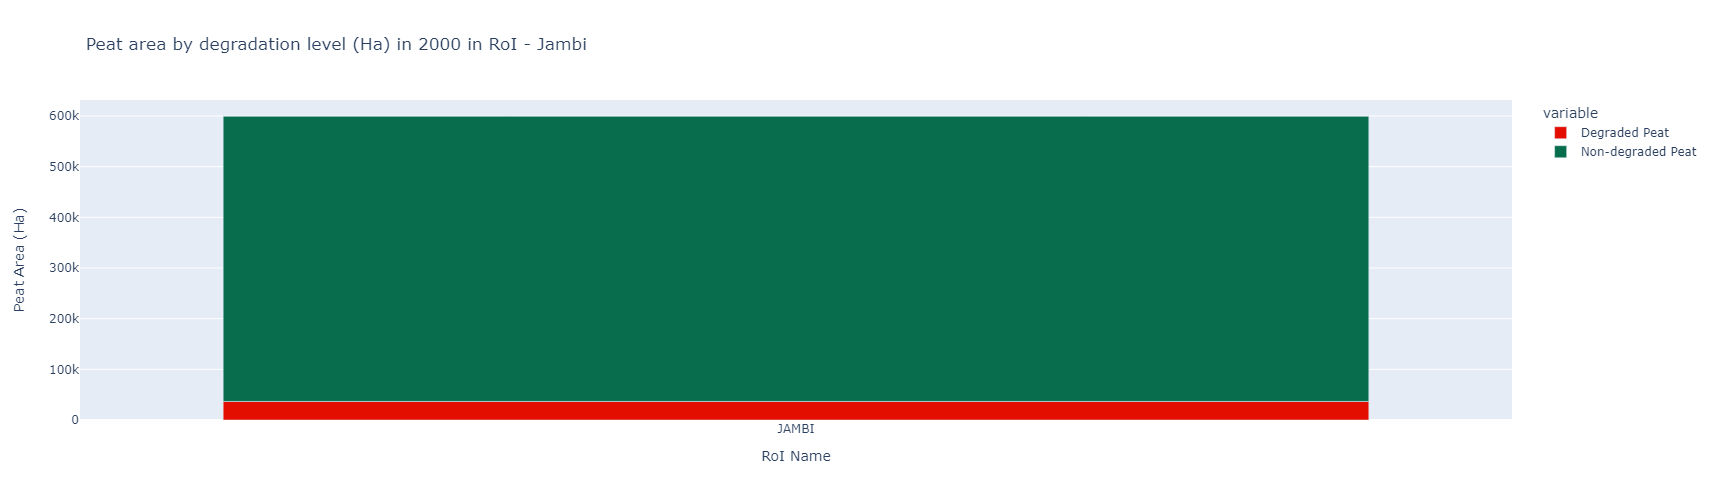

In [67]:
# Degraded Peat area in RoI
fig_degpeatarea_00 = px.bar(degradation_peatforestype_2000_df, x = roi_column_name, y = ["Degraded Peat", "Non-degraded Peat"],
                         category_orders={"Degraded Peat": ["Degraded Peat", "Non-degraded Peat"]},
                         color_discrete_sequence = ['#e30d00', '#076d4d'],
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name","value": "Peat Area (Ha)"},
                         title ="Peat area by degradation level (Ha) in 2000 in RoI - " + projectname)
fig_degpeatarea_00

### Degraded Peat in 2022

In [49]:
# 2. Primary Forest + Non-prmary forest 2022
# Note: Primary Forest * 10 + Non-primary Forest
# 0: Non-forest
# 1: Non-primary Forest
# 10: Primary Forest
# 11: Primary Forest
# Create parameters from converting numpy to raster
upperleft_bound_22 = primaryforest22_geotiff.transform * (0, 0)
pixel_size_22 = primaryforest22_geotiff.transform[0]

# overlay primary + non-primary forest
forestbytype_loss_overlay_22 = primaryforest22_geotiff.read(1) * 10 + Nonprimaryforest22_geotiff.read(1)

new_transform_22 = rasterio.transform.from_origin(upperleft_bound_22[0],upperleft_bound_22[1],pixel_size_22,pixel_size_22)
new_dataset_22 = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_2022_roi.tif').replace(os.sep, '/'), "w+", 
    driver = "GTiff",
    height = forestbytype_loss_overlay_22.shape[0],
    width = forestbytype_loss_overlay_22.shape[1],
    count = 1,
    #nodata = 0,
    dtype = forestbytype_loss_overlay_22.dtype,
    crs = projection,
    transform = new_transform_22
)
new_dataset_22.write(forestbytype_loss_overlay_22, 1)
new_dataset_22.close()

In [50]:
PrimForestNonPrimFores_22_raster = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_2022_roi.tif').replace(os.sep, '/'))

In [51]:
# overlay forest type by peat and non-peat
# peat * 100 + foresttype
#  100: non-forested peat -- degraded peat
#  101: peat - nonprimary forest -- forested peat
#  110 & 111 : peat - primary forest -- forested peat
#  200: non-peat and non-forested -- nonpeat nonforested
#  201: nonpeat - nonprimaryforest --- forested area
#  210 & 211: non peat - primary forest --- forested area

upperleft_bound2_22 = PrimForestNonPrimFores_22_raster.transform * (0, 0)
pixel_size2_22 = PrimForestNonPrimFores_22_raster.transform[0]

forestbytype_soiltype_loss_overlay_22 = peatnonpeat_raster.read(1) * 100 + PrimForestNonPrimFores_22_raster.read(1)

new_transform2_22 = rasterio.transform.from_origin(upperleft_bound2_22[0],upperleft_bound2_22[1],pixel_size2_22,pixel_size2_22)

new_dataset_peat_forest_22 = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_2022_roi.tif').replace(os.sep, '/'), "w+", 
    driver = "GTiff",
    height = forestbytype_soiltype_loss_overlay_22.shape[0],
    width = forestbytype_soiltype_loss_overlay_22.shape[1],
    count = 1,
    nodata = 0,
    dtype = forestbytype_soiltype_loss_overlay_22.dtype,
    crs = projection,
    transform = new_transform2_22
)
new_dataset_peat_forest_22.write(forestbytype_soiltype_loss_overlay_22, 1)
new_dataset_peat_forest_22.close()

In [52]:
pnp_forest_2022 = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_2022_roi.tif').replace(os.sep, '/'))

In [53]:
# zonal histogram of peat + foresttype 2022
zs_soiltype_foresttype_22 = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                        raster = os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_2022_roi.tif').replace(os.sep, '/'), categorical=True)
zs_soiltype_foresttype_22_df = pd.DataFrame(zs_soiltype_foresttype_22).fillna(0)
# Estimate Area from pixels count
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df * 30 *30 /10000
zs_soiltype_foresttype_22_df["total_area_ha"] = zs_soiltype_foresttype_22_df.sum(axis=1)
# rename coloumn based on degradation category
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df.rename({ 100.0: 'Degraded Peat', 101.0: 'Non-degraded Peat', 110.0 : 'Non-degraded Peat', 
                                                                    200.0: 'Non-peat Non-Forest', 201.0: 'Non-peat Non-prim Forest', 210.0:'Non-peat PrimForest'}, axis='columns')
# sum the duplicated columns
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df.groupby(lambda x:x, axis=1).sum()

In [64]:
# join between degradation area table with roi_table
degradation_peatforestype_2022 = peat_nonpeat_roi_proj.join(zs_soiltype_foresttype_22_df)
degradation_peatforestype_2022_df = pd.DataFrame(degradation_peatforestype_2022).fillna(0)
degradation_peatforestype_2022_df = degradation_peatforestype_2022_df.loc[(degradation_peatforestype_2022_df[[roi_column_name]] != 0).all(axis=1)]

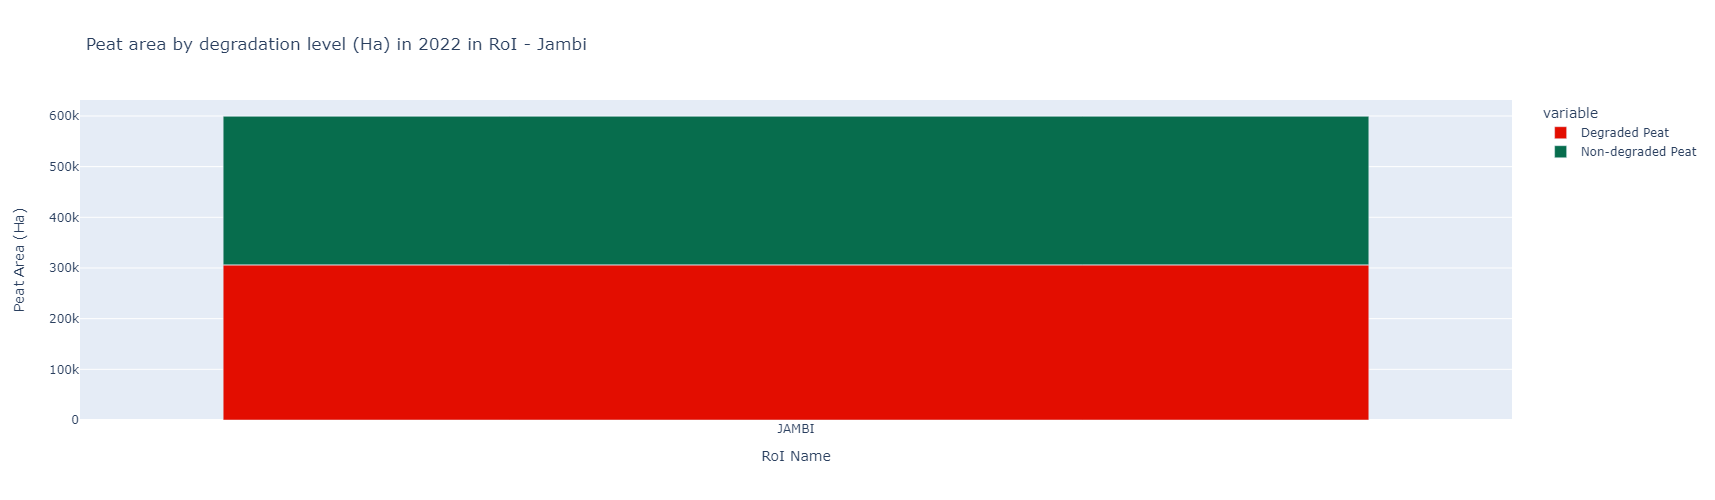

In [65]:
# Degraded Peat area in RoI
fig_degpeatarea_22 = px.bar(degradation_peatforestype_2022_df, x = roi_column_name, y = ["Degraded Peat", "Non-degraded Peat"],
                         category_orders={"Degraded Peat": ["Degraded Peat", "Non-degraded Peat"]},
                         color_discrete_sequence = ['#e30d00', '#076d4d'],
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name","value": "Peat Area (Ha)"},
                         title ="Peat area by degradation level (Ha) in 2022 in RoI - " + projectname)
fig_degpeatarea_22

## Export Data

In [68]:
# Export csv file
# 1. Peatland Area
peat_nonpeat_roi_proj.to_csv(os.path.join(out_dir, projectname + '_RoI_PeatArea.csv'))
# 2. Degraded peat based on Forested area in 2000 and 2001
degradation_peatforestype_2000_df = degradation_peatforestype_2000_df.drop('geometry', axis =1 )
degradation_peatforestype_2000_df.to_csv(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2000_2001.csv'))
#degradation_peatforestype_2000.to_file(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2000_2001.shp'))

# 3. Degraded peat based on Forested area in 2022
degradation_peatforestype_2022_df = degradation_peatforestype_2022_df.drop('geometry', axis =1)
degradation_peatforestype_2022_df.to_csv(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2022.csv'))
#degradation_peatforestype_2022.to_file(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2022.shp'))

In [69]:
# Export Grapph
# 1. Peat Area
fig_peatarea.write_image(os.path.join(out_dir, projectname + '_RoI_PeatArea_Graph.png'))
# 2. Degraded peat in 2000/2001
fig_degpeatarea_00.write_image(os.path.join(out_dir, projectname + '_RoI_DegradedPeatArea_2000_Graph.png'))
# 3. Degraded peat in 2022
fig_degpeatarea_22.write_image(os.path.join(out_dir, projectname + '_RoI_DegradedPeatArea_2022_Graph.png'))